# Tunnel Score Exploratory Data Analysis

Jensen Holm

Sep. 2024

In [25]:
import polars as pl
import datetime
import pybaseball
from pybaseball import cache
from utils import pl_euclidean_distance, plot_strike_zone_heatmap
import matplotlib.pyplot as plt
import seaborn as sns

cache.enable()

orig_df = pl.from_pandas(
    pybaseball.statcast(
        start_dt="2023-03-01",
        end_dt=datetime.datetime.today().strftime("%Y-%m-%d"),
    )
)

orig_df.sample(3, seed=1)

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


  0%|          | 1/421 [00:05<38:05,  5.44s/it]/Users/jensen/Documents/projects/TunnelScoreEDA/venv/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/Users/jensen/Documents/projects/TunnelScoreEDA/venv/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  0%|          | 2/421 [00:06<19:07,  2.74s/it]/Users/jensen/Documents/projects/TunnelScoreEDA/venv/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: Fut

pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,…,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length
str,datetime[ns],f64,f64,f64,str,i64,i64,str,str,i64,i64,i64,i64,i64,str,str,str,str,str,str,str,i64,str,i64,i64,i64,f64,f64,f64,f64,i64,i64,i64,i64,i64,str,…,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,str,str,i64,f64,f64,f64,f64
"""SL""",2023-07-01 00:00:00,87.1,-1.76,6.14,"""Bradish, Kyle""",572191,680694,null,"""ball""",null,null,null,null,11,"""Michael A. Taylor strikes ou…","""R""","""R""","""R""","""BAL""","""MIN""","""B""",null,null,0,0,2023,1.33,0.06,-1.03,4.13,null,596146,608336,2,2,"""Top""",…,6.4,717541,680694,668939,656811,624428,676059,683002,669720,656775,543305,54.09,null,null,null,null,null,null,null,12,1,"""Slider""",0,0,0,0,0,0,0,0,"""Standard""","""Standard""",61,0.0,0.048,null,null
"""FF""",2024-04-29 00:00:00,91.5,-2.39,6.27,"""Richards, Trevor""",592669,670950,"""field_out""","""hit_into_play""",null,null,null,null,8,"""Hunter Renfroe grounds out, sh…","""R""","""R""","""R""","""TOR""","""KC""","""X""",6,"""ground_ball""",1,0,2024,-0.74,1.56,-0.23,1.7,null,null,null,0,6,"""Top""",…,6.1,744945,670950,643376,665489,624415,680718,643396,676914,662139,543807,54.4,0.606,0.57,0.0,1,0,0,4,52,2,"""4-Seam Fastball""",5,3,3,5,3,5,3,5,"""Infield shade""","""Standard""",203,0.03,-0.262,71.11742,7.5937
"""FS""",2023-09-28 00:00:00,84.8,-1.89,5.87,"""Maeda, Kenta""",680869,628317,null,"""foul""",null,null,null,null,14,"""Zack Gelof strikes out swingin…","""R""","""R""","""R""","""MIN""","""OAK""","""S""",null,null,2,2,2023,-0.95,-0.04,0.54,1.2,null,null,null,0,8,"""Top""",…,6.3,716400,628317,680777,666135,456781,650489,571657,670242,572191,663616,54.21,null,null,null,null,null,null,null,59,5,"""Split-Finger""",1,2,2,1,2,1,2,1,"""Infield shade""","""Standard""",247,0.0,0.0,null,null


In [26]:
# documentation on the columns here: https://baseballsavant.mlb.com/csv-docs
orig_df.columns

['pitch_type',
 'game_date',
 'release_speed',
 'release_pos_x',
 'release_pos_z',
 'player_name',
 'batter',
 'pitcher',
 'events',
 'description',
 'spin_dir',
 'spin_rate_deprecated',
 'break_angle_deprecated',
 'break_length_deprecated',
 'zone',
 'des',
 'game_type',
 'stand',
 'p_throws',
 'home_team',
 'away_team',
 'type',
 'hit_location',
 'bb_type',
 'balls',
 'strikes',
 'game_year',
 'pfx_x',
 'pfx_z',
 'plate_x',
 'plate_z',
 'on_3b',
 'on_2b',
 'on_1b',
 'outs_when_up',
 'inning',
 'inning_topbot',
 'hc_x',
 'hc_y',
 'tfs_deprecated',
 'tfs_zulu_deprecated',
 'fielder_2',
 'umpire',
 'sv_id',
 'vx0',
 'vy0',
 'vz0',
 'ax',
 'ay',
 'az',
 'sz_top',
 'sz_bot',
 'hit_distance_sc',
 'launch_speed',
 'launch_angle',
 'effective_speed',
 'release_spin_rate',
 'release_extension',
 'game_pk',
 'pitcher.1',
 'fielder_2.1',
 'fielder_3',
 'fielder_4',
 'fielder_5',
 'fielder_6',
 'fielder_7',
 'fielder_8',
 'fielder_9',
 'release_pos_y',
 'estimated_ba_using_speedangle',
 'estimat

## Tying pitches to their previous ones

This will allow us to compare each pitch to the one before it, giving us the ability to calculate tunnel score.

In [27]:
# first we need to sort all the pitches

SORT_COLS = [
    "game_date",
    "pitcher",
    "at_bat_number",
    "pitch_number",
]

shifted_df = orig_df.sort(SORT_COLS, descending=True)

OVER_COLS = ["at_bat_number", "pitcher"]
# now we can shift the data by one row to get the previous pitch data for each pitch in one row
for col_name in shifted_df.columns:
    shifted_df = shifted_df.with_columns(
        pl.col(col_name).shift(-1).over(OVER_COLS).alias(f"prev_{col_name}")
    )

shifted_df.select(SORT_COLS).sample(5, seed=1)

game_date,pitcher,at_bat_number,pitch_number
datetime[ns],i64,i64,i64
2023-07-01 00:00:00,656427,2,1
2024-06-28 00:00:00,544150,3,5
2024-04-29 00:00:00,572020,34,1
2023-04-03 00:00:00,664208,40,1
2024-07-27 00:00:00,593576,75,4


## Adding Tunnel Score

```math
TunnelScore = log_{2}( (\frac{TunnelDistance}{ActualDistance}) - ReleaseDistance)
```

Where ...

**ReleaseDistance** = euclidean distance between the release points of current pitch and the previous pitch

**ActualDistance** = euclidean distance between where the current pitch ended up over the plate, and the previous pitch 

**TunnelDistance** = euclidean distance between where the current pitch would have ended up without movement, and the same for the previous pitch 

In [28]:
# compute where the pitch and the previous one would have been if they had no movement
tunnel_distance_df: pl.DataFrame = shifted_df.with_columns(
    plate_x_no_move=pl.col("plate_x")
    - pl.col("pfx_x"),  # x coord of the pitch if it had no movement
    plate_z_no_move=pl.col("plate_z")
    - pl.col("pfx_z"),  # z coord of the pitch if it had no movement
    prev_plate_x_no_move=pl.col("prev_plate_x")
    - pl.col("prev_pfx_x"),  # x coord of the previous pitch if it had no movement
    prev_plate_z_no_move=pl.col("prev_plate_z")
    - pl.col("prev_pfx_z"),  # z coord of the previous pitch if it had no movement
)

tunnel_cols_df: pl.DataFrame = tunnel_distance_df.with_columns(
    # tunnel_distance is the distance between the pitch and the previous pitch if they had no movement
    tunnel_distance=pl_euclidean_distance(
        x1=pl.col("plate_x_no_move"),
        y1=pl.col("plate_z_no_move"),
        x2=pl.col("prev_plate_x_no_move"),
        y2=pl.col("prev_plate_z_no_move"),
    ),
    # actual_distance is the distance between the pitch and the previous pitch
    actual_distance=pl_euclidean_distance(
        x1=pl.col("plate_x"),
        y1=pl.col("plate_z"),
        x2=pl.col("prev_plate_x"),
        y2=pl.col("prev_plate_z"),
    ),
    # release_distance is the distance between the release point of the pitch and the previous pitch
    release_distance=pl_euclidean_distance(
        x1=pl.col("release_pos_x"),
        y1=pl.col("release_pos_z"),
        x2=pl.col("prev_release_pos_x"),
        y2=pl.col("prev_release_pos_z"),
    ),
)

TUNNEL_COLS = [
    "tunnel_distance",
    "actual_distance",
    "release_distance",
]

tunnel_cols_df.select(SORT_COLS + TUNNEL_COLS).sample(5, seed=1)

game_date,pitcher,at_bat_number,pitch_number,tunnel_distance,actual_distance,release_distance
datetime[ns],i64,i64,i64,f64,f64,f64
2023-07-01 00:00:00,656427,2,1,9.3225,7.3424,0.12
2024-06-28 00:00:00,544150,3,5,2.1241,2.4125,0.5241
2024-04-29 00:00:00,572020,34,1,2.3429,1.7881,0.1125
2023-04-03 00:00:00,664208,40,1,null,null,null
2024-07-27 00:00:00,593576,75,4,0.6025,1.1881,0.1889


In [33]:
# now we can add tunnel score column using the tunnel_distance, actual_distance, and release_distance

# adding this if statement to avoid adding the same column multiple times
# because the nature of jupyter notebooks
if "tunnel_score" not in TUNNEL_COLS:
    TUNNEL_COLS.append("tunnel_score")

tunnel_score_df = tunnel_cols_df.with_columns(
    tunnel_score=(pl.col("actual_distance") / pl.col("tunnel_distance"))
    - pl.col("release_distance").log(base=2),
).drop_nulls(subset=TUNNEL_COLS)

print(f"shape of dataframe with tunnel score: {tunnel_score_df.shape}")
tunnel_score_df.select(SORT_COLS + TUNNEL_COLS + ["player_name"]).sample(5, seed=1)

shape of dataframe with tunnel score: (1329833, 196)


game_date,pitcher,at_bat_number,pitch_number,tunnel_distance,actual_distance,release_distance,tunnel_score,player_name
datetime[ns],i64,i64,i64,f64,f64,f64,f64,str
2023-07-06 00:00:00,682227,12,2,8.9716,1.3925,0.1089,3.354136,"""Williamson, Brandon"""
2024-08-23 00:00:00,605135,26,4,0.7341,0.75,0.0536,5.243282,"""Bassitt, Chris"""
2024-05-04 00:00:00,671096,19,7,2.3576,2.5461,0.0625,5.079954,"""Abbott, Andrew"""
2023-09-30 00:00:00,674681,5,2,1.4176,1.3044,0.0925,4.35455,"""Plassmeyer, Michael"""
2023-04-10 00:00:00,605218,74,6,1.3769,1.6776,0.1464,3.990402,"""Edwards Jr., Carl"""


In [34]:
tunnel_score_df.select("tunnel_score").describe()

statistic,tunnel_score
str,f64
"""count""",1.329833e6
"""null_count""",0.0
"""mean""",inf
"""std""",NaN
"""min""",-3.442162
"""25%""",3.321899
"""50%""",4.484409
"""75%""",5.817127
"""max""",inf


In [35]:
no_inf_df = tunnel_score_df.filter(pl.col("tunnel_score") != float("inf"), pl.col("tunnel_score") > 0.0)

no_inf_df.select("tunnel_score").describe()

statistic,tunnel_score
str,f64
"""count""",1.325317e6
"""null_count""",0.0
"""mean""",2.5449e27
"""std""",2.2200e30
"""min""",0.000369
"""25%""",3.329768
"""50%""",4.487073
"""75%""",5.815453
"""max""",2.4513e33


## AB Level Visualizations

**Interests**:
1. How does tunnel score relate to getting outs? Strikeouts? Delta Run Expectancy? (if at all)
2. Do certian pitches have high tunnel scores?
3. Are there certain pitchers who are better at it than others? More consistent? 
4. Are there certain locations in the zone that have higher or lower tunnel scores? Does this correlate with delta run exp?

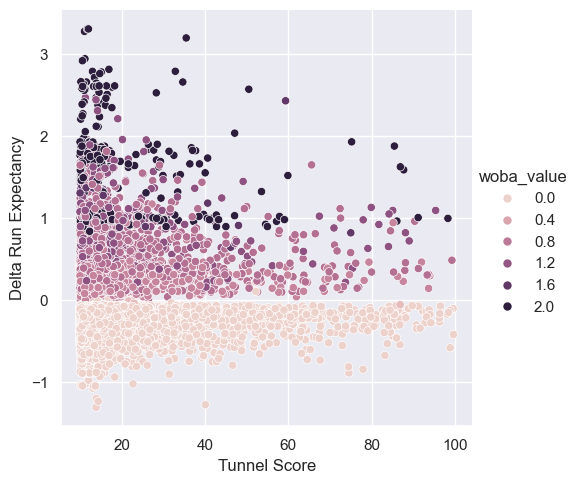

In [36]:
# correlation with delta run expectancy

sns.set_theme(palette='rocket')

sns.relplot(
    data=no_inf_df.filter(pl.col("tunnel_score") > 10.0, pl.col("tunnel_score") < 100).to_pandas(),
    x="tunnel_score",
    y="delta_run_exp",
    hue="woba_value",
)

plt.ylabel("Delta Run Expectancy")
plt.xlabel("Tunnel Score")

plt.show()

/Users/jensen/Documents/projects/TunnelScoreEDA/utils/plot_tunnel.py:191: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["z_bin", "x_bin"])[stat_column].agg(agg_function).unstack()


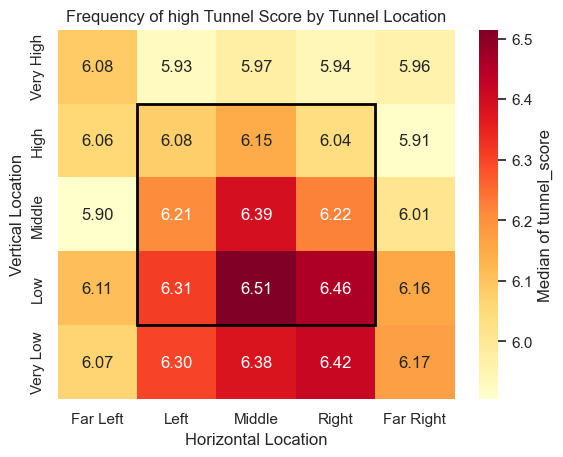

In [57]:
# high tunnel score with a good result
high_tunnel_score_df = (
    tunnel_score_df
    .filter(pl.col("tunnel_score") >= 5.0)
    .filter(pl.col("tunnel_score") != float("inf"))
    .filter(pl.col("strikes") == 2)
)

plot_strike_zone_heatmap(
    data=high_tunnel_score_df.to_pandas(),
    stat_column="tunnel_score",
    agg_function="median",
    title="Frequency of high Tunnel Score by Tunnel Location",
    plate_loc_x="plate_x_no_move",
    plate_loc_z="plate_z_no_move",
)

plt.show()

# _ = plot_strike_zone(
#     data=no_inf_df.filter(pl.col("tunnel_score") >= 10.0).sample(50, seed=2).to_pandas(),
#     colorby="tunnel_score",
#     annotation=None,
#     plate_loc_x="plate_x_no_move",
#     plate_loc_z="plate_z_no_move",
#     title="Tunnel Score by Tunnel Location",
# )


/Users/jensen/Documents/projects/TunnelScoreEDA/utils/plot_tunnel.py:191: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["z_bin", "x_bin"])[stat_column].agg(agg_function).unstack()


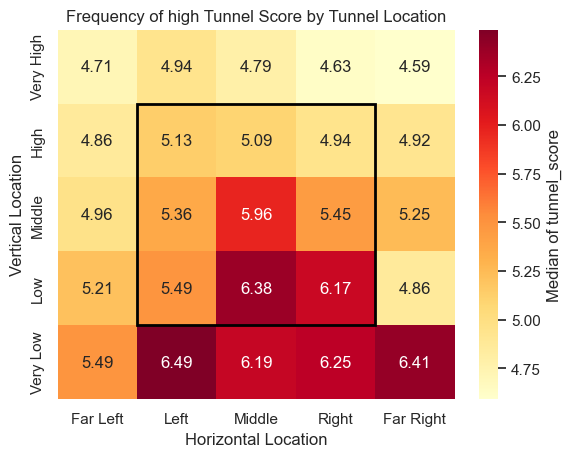

In [62]:
# high tunnel score with a bad result 
high_tunnel_score_bad_result_df = (
    tunnel_score_df
    .filter(pl.col("tunnel_score") >= 4.0)
    .filter(pl.col("delta_run_exp") < 0)
    .filter(pl.col("prev_pitch_type") == "FF")
    .filter(pl.col("pitch_type") == "CU")
    .filter(pl.col("type") == "S")
    # .filter(pl.col("tunnel_score") != float("inf"))
)

_ = plot_strike_zone_heatmap(
    data=high_tunnel_score_bad_result_df.to_pandas(),
    stat_column="result",
    agg_function="median",
    title="Frequency of high Tunnel Score by Tunnel Location",
    plate_loc_x="plate_x_no_move",
    plate_loc_z="plate_z_no_move",
)

## Joining with FanGraphs data

We are interested to see if at bats with a high avg, median, max, tunnel score have a relationship with good results for the pitcher. Currently the data we have is just statcast pitch level data, so we are going to join it with season summary data from fangraphs and aggregate tunnel score metrics.

In [ ]:
# first loading other player data to join with statcast data
fangraphs_pitching_df = pybaseball.pitching_stats(2024)

player_fg_ids_df = pybaseball.playerid_reverse_lookup(
    fangraphs_pitching_df["IDfg"].unique().tolist(), key_type="fangraphs"
)

player_ids_df = pl.from_pandas(fangraphs_pitching_df).join(
    other=pl.from_pandas(player_fg_ids_df),
    left_on="IDfg",
    right_on="key_fangraphs",
    how="left",
    validate="1:1",
)

player_ids_df.sample(5, seed=1)

Gathering player lookup table. This may take a moment.


IDfg,Season,Name,Team,Age,W,L,WAR,ERA,G,GS,CG,ShO,SV,BS,IP,TBF,H,R,ER,HR,BB,IBB,HBP,WP,BK,SO,GB,FB,LD,IFFB,Balls,Strikes,Pitches,RS,IFH,BU,…,Stf+ CH,Loc+ CH,Pit+ CH,Stf+ CU,Loc+ CU,Pit+ CU,Stf+ FA,Loc+ FA,Pit+ FA,Stf+ SI,Loc+ SI,Pit+ SI,Stf+ SL,Loc+ SL,Pit+ SL,Stf+ KC,Loc+ KC,Pit+ KC,Stf+ FC,Loc+ FC,Pit+ FC,Stf+ FS,Loc+ FS,Pit+ FS,Stuff+,Location+,Pitching+,Stf+ FO,Loc+ FO,Pit+ FO,name_last,name_first,key_mlbam,key_retro,key_bbref,mlb_played_first,mlb_played_last
i64,i64,str,str,i64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,f64,f64,f64,str,str,i64,str,str,f64,f64
9803,2024,"""Miles Mikolas""","""STL""",35,8,10,1.9,5.27,28,28,0,0,0,0,153.2,642,171,93,90,22,24,0,3,0,1,107,216,181,108,19,770,1636,2406,73,15,2,…,86.0,103.0,98.0,96.0,108.0,105.0,66.0,107.0,97.0,83.0,110.0,98.0,116.0,111.0,114.0,null,null,null,null,null,null,null,null,null,89,108,102,null,null,null,"""mikolas""","""miles""",571945,"""mikom001""","""mikolmi01""",2012.0,2024.0
10310,2024,"""Zack Wheeler""","""PHI""",34,13,6,4.4,2.63,27,27,0,0,0,0,167.2,665,119,54,49,17,45,0,8,8,0,183,180,167,80,25,924,1735,2659,96,11,2,…,null,null,null,111.0,101.0,107.0,100.0,107.0,110.0,111.0,103.0,108.0,128.0,107.0,116.0,null,null,null,92.0,97.0,95.0,95.0,107.0,107.0,105,105,108,null,null,null,"""wheeler""","""zack""",554430,"""wheez001""","""wheelza01""",2013.0,2024.0
19879,2024,"""Tanner Houck""","""BOS""",28,8,9,3.6,3.12,27,27,1,1,0,0,164.2,689,146,70,57,10,46,1,15,2,0,143,268,116,98,6,857,1678,2535,101,14,2,…,null,null,null,null,null,null,null,null,null,93.0,102.0,96.0,117.0,98.0,109.0,null,null,null,95.0,93.0,93.0,116.0,103.0,110.0,109,101,105,null,null,null,"""houck""","""tanner""",656557,"""houct001""","""houckta01""",2020.0,2024.0
16149,2024,"""Aaron Nola""","""PHI""",31,12,6,2.9,3.29,28,28,1,1,0,0,172.1,700,155,67,63,24,43,0,3,2,0,162,215,169,107,14,929,1778,2707,109,10,1,…,79.0,102.0,90.0,null,null,null,90.0,103.0,99.0,100.0,111.0,108.0,null,null,null,135.0,107.0,114.0,69.0,98.0,92.0,null,null,null,104,105,104,null,null,null,"""nola""","""aaron""",605400,"""nolaa001""","""nolaaa01""",2015.0,2024.0
9132,2024,"""Nathan Eovaldi""","""TEX""",34,10,7,2.6,3.6,24,24,0,0,0,0,140.0,564,117,57,56,18,32,0,6,3,0,138,191,119,76,9,693,1463,2156,75,6,2,…,null,null,null,101.0,103.0,104.0,75.0,106.0,99.0,null,null,null,115.0,100.0,103.0,null,null,null,91.0,107.0,98.0,127.0,102.0,111.0,98,105,104,null,null,null,"""eovaldi""","""nathan""",543135,"""eovan001""","""eovalna01""",2011.0,2024.0


In [ ]:
# NOTE: this drops some data for newer players that are not in the playerid_reverse_lookup
# (you can see this in the difference of the shapes of this dataframe and tunnel_score_df)
tunnel_score_fg_df = tunnel_score_df.join(
    other=player_ids_df,
    left_on="pitcher",
    right_on="key_mlbam",
    how="inner",  # getting rid of players that are not in the fangraphs_pitching_df
    validate="m:1",
)

print(f"tunnel score fangraphs df shape: {tunnel_score_fg_df.shape}")
tunnel_score_fg_df.select(
    SORT_COLS + TUNNEL_COLS + ["player_name", "BB%", "K%"]
).sample(5, seed=1)

tunnel score fangraphs df shape: (151876, 595)


game_date,pitcher,at_bat_number,pitch_number,tunnel_distance,actual_distance,release_distance,tunnel_score,player_name,BB%,K%
datetime[ns],i64,i64,i64,f64,f64,f64,f64,str,f64,f64
2024-08-28 00:00:00,669022,42,4,0.3941,0.3369,0.0716,4.97368,"""Gore, MacKenzie""",0.089,0.235
2024-08-06 00:00:00,664285,21,1,4.5881,0.9316,0.3964,6.259939,"""Valdez, Framber""",0.079,0.244
2024-07-09 00:00:00,669302,57,2,1.4744,2.9841,0.2884,2.287942,"""Gilbert, Logan""",0.047,0.265
2024-06-18 00:00:00,664285,23,1,1.8401,1.23,0.1836,3.941378,"""Valdez, Framber""",0.079,0.244
2024-08-17 00:00:00,656302,4,4,2.2309,2.0725,0.0136,7.276679,"""Cease, Dylan""",0.087,0.303


## Interpretation of Visualizations

1. **Scatter plot of tunnel score vs. strikeout percentage (K%)**: This visualization helps us understand if there's a relationship between a pitcher's ability to create tunneling effects and their strikeout rate. A positive correlation would suggest that better tunneling (higher tunnel scores) leads to more strikeouts.

2. **Box plot of tunnel score distribution for different pitch types**: This plot allows us to compare how different pitch types perform in terms of tunneling. We can identify which pitch types generally have higher tunnel scores and which ones have more variability.

3. **Heatmap of average tunnel score by pitch location**: This heatmap gives us insights into which areas of the strike zone (and outside it) tend to produce better tunneling effects. This could be valuable for pitch sequencing and game planning.

4. **Bar chart of top pitchers by average tunnel score**: This chart highlights the pitchers who are most effective at creating tunneling effects. It can be used to identify pitchers who might be outperforming their traditional statistics due to their tunneling ability.

These visualizations provide a comprehensive view of how the tunnel score metric relates to various aspects of pitching performance and can be used to gain insights into pitcher effectiveness and potential areas for improvement.